<a href="https://colab.research.google.com/github/elliemci/building-LLM/blob/main/openAIpretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using OpenAI pretrained weights for GPT-2

Load weights into GPTModel class to use for text generation. The publicly avilable OpenAI GPT-2weights aree downloadeed and transfered from the `settings` and `params` dictionaries into. the GPTModel instance.

OpenAI originally saved the GPT-2 weights via TensorFlow

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/LLM
%ls

/content/drive/MyDrive/Colab Notebooks/LLM
attention_comp.ipynb      gpt_model.png                  the-verdict.txt
attention_comp.py         model.pth                      token_embedding.ipynb
gpt2/                     openAIpretrained.ipynb         tokenizing_text.ipynb
gpt2_pretrained.png       pytorch_wormup.ipynb           training.ipynb
gpt_download.py           randomness_control.ipynb       training.py
gpt_implementation.ipynb  sliding_window_sampling.ipynb
gpt_implementation.py     sliding_window_sampling.py


In [ ]:
!pip install tensorflow  tqdm

In [ ]:
import torch
import tqdm
import tensorflow as tf

print(tqdm.__version__)
print(tf.__version__)

4.66.2
2.15.0


## Load GPT-2 model weights

Load GPT-2 architecture settings and weight parameters using the download_and_load_gpt2 function from the gpt_download.py

In [ ]:
# downloads the files associated with the 124M parameter GPT-2 model
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
print("LLM architecture settings:", settings)
print("Weight tensors:", params.keys())

LLM architecture settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Weight tensors: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print("Token embedding weight tensor dimensions:", params["wte"].shape)
print("embeding layer weights:", params["wte"])

Token embedding weight tensor dimensions: (50257, 768)
embeding layer weights: [[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]


GPT-2 comes in different model sizes: 124 million, 355 million, 774 million, 1558 million parameters, which have the same core architecturew but differ in emebedding size and number of times attention heads and transformer bocks are repeated.

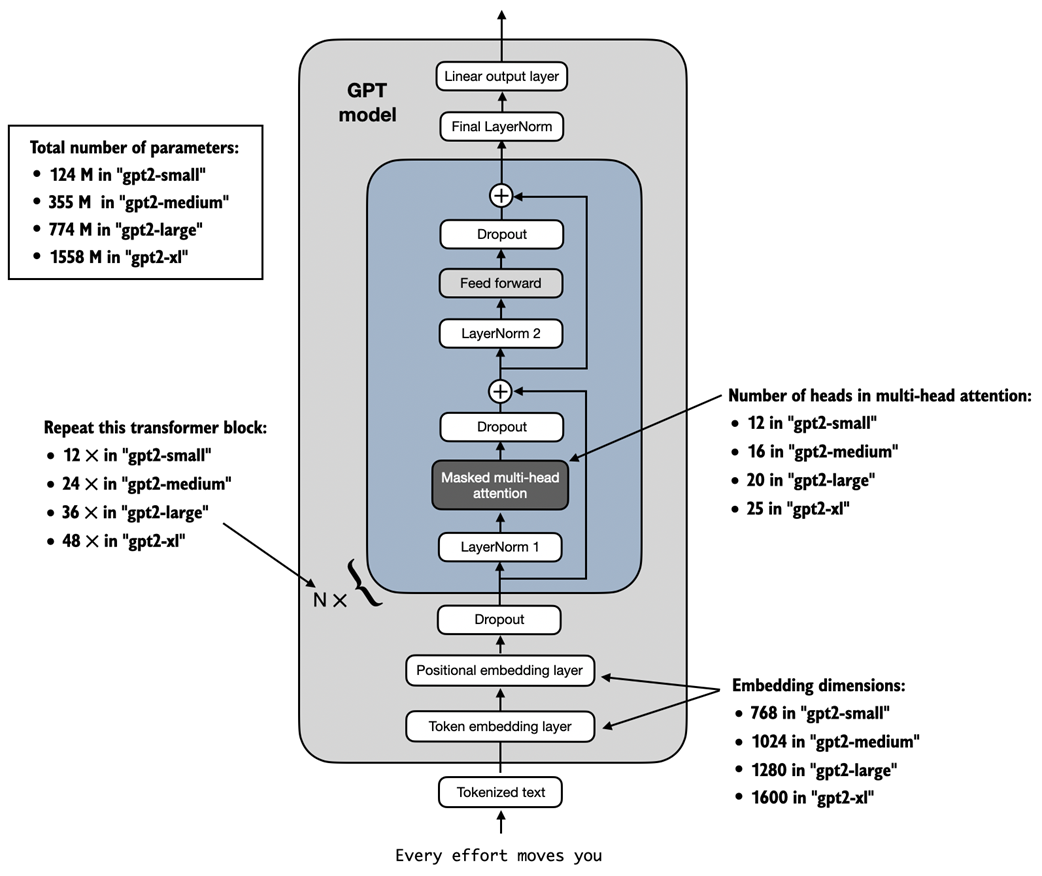

In [ ]:
from IPython.display import Image
Image(filename='gpt2_pretrained.png')

In [ ]:
# dictionary that lists the different GPT model sizes
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

## Transfer GPT-2 weights into GPT model instance

Load the smallest and use the corresponding settings from model_configs to update previously used 256-token length with the OpenAI 1024-token length and the use of the bias vectors in the multi-head attention for implementation of the query, key and value matrix computations

In [ ]:
# previously defined GPTModel configurations
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False}

model_name = "gpt2-small (124M)"

NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

Initialize an GPTModel instance with NEW_CONFIG dictionary

In [ ]:
from gpt_implementation import GPTModel

torch.manual_seed(123)
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

Override the initial random weights with the loaded weight from params dictionary

In [ ]:
def assign(left, right):
  """ Utility function that checks whether two tensors have the same dimensions
      and if so returns the right tensor parameters """
  if left.shape != right.shape:
      raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
  """ Function that loads the weights from the params dictionary into the
      GPTModel instance gpt. """

  # set models positional and token embedding weights
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

  # iterate over each transformer block
  for b in range(len(params["blocks"])):
    # use np.split to divide the attention and its bias weights into
    # three equal parts for the query, key and value components
    q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

    gpt.trf_blocks[b].att.Wq.weight = assign(gpt.trf_blocks[b].att.Wq.weight, q_w.T)
    gpt.trf_blocks[b].att.Wk.weight = assign(gpt.trf_blocks[b].att.Wk.weight, k_w.T)
    gpt.trf_blocks[b].att.Wv.weight = assign(gpt.trf_blocks[b].att.Wv.weight, v_w.T)

    q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

    gpt.trf_blocks[b].att.Wq.bias = assign(gpt.trf_blocks[b].att.Wq.bias, q_b)
    gpt.trf_blocks[b].att.Wk.bias = assign(gpt.trf_blocks[b].att.Wk.bias, k_b)
    gpt.trf_blocks[b].att.Wv.bias = assign(gpt.trf_blocks[b].att.Wv.bias, v_b)

    # OpenAI stores the wieght tensor for the output projection layer for the
    # first transformer block as params["blocks"][0]["attn"]["c_proj"]["w"], which
    # correspind to the GPTModel implementation of gpt.trf_blocks[b].att.out_proj.weight
    gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight,
                                                   params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias,
                                                 params["blocks"][b]["attn"]["c_proj"]["b"])
    gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight,
                                                   params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias,
                                                 params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight,
                                                 params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias,
                                                 params["blocks"][b]["mlp"]["c_proj"]["b"])

    gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale,
                                           params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift,
                                           params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale,
                                           params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift,
                                           params["blocks"][b]["ln_2"]["b"])

    # Weight tying is the reuse of the token embedding weights in the otput layer
    # in order to reduce the total number of parameters
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## Load the model

In [ ]:
load_weights_into_gpt(gpt, params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device)

## Generate new text

In [ ]:
! jupyter nbconvert --to python randomness_control.ipynb

[NbConvertApp] Converting notebook randomness_control.ipynb to python
[NbConvertApp] Writing 6667 bytes to randomness_control.py


In [ ]:
def text_to_token_ids(text, tokenizer, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    """ Combine teperature scaling and top-k sampling to generate new text,
        intead of memorizing one. """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
# from train import text_to_token_ids, token_ids_to_text
# from randomness_control import generate
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

In [ ]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
